<a href="https://colab.research.google.com/github/eduardoplima/ml-licitacoes/blob/main/licitacoes_naosupervisionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelos não supervisionados para análise de licitações

As aquisições de produtos e contratações de serviços realizadas por órgãos públicos são regradas pela nova Lei de Licitações e Contratos Administrativos (Lei n° 14.133/2021). A legislação abrange todas as etapas, desde a preparação até a execução e fiscalização dos contratos. A fiscalização desse processo é exercida principalmente pelos Tribunais de Contas, que monitoram o cumprimento da legislação e examinam a conformidade e a eficiência dos gastos públicos.

No caso específico do TCE-RN, os processos licitatórios são enviados por meio de um sistema de prestação de contas (SIAI). Cada procedimento é descrito por um campo `objeto`, além de atributos que classificam os itens adquiridos (tais como `classificacao_objeto` ou `elemento_despesa`). Ademais, cada licitação se subdivide em lotes, que representam produtos adquiridos e possuem um campo `descricao`.

Pedidos de informações de tipos não diretamente descritos pelos atributos da base de dados do SIAI é comum. Por exemplo, gastos com publicidade em determinado município. Assim como a aquisição de panfletos se encaixa no pedido, a solicitação também abrange serviços de divulgação em canais de mídia. Sendo assim, há opotunidade para o uso de técnicas de aprendizado de máquina.

Nesse notebook as descrições de objeto e lotes de licitações serão utilizadas para o agrupamento de lotes semelhantes. As palavras mais comum nesses grupo servirão para criar classes de grupo, possibilitando encontrar licitações com produtos ou serviços da mesma natureza.

In [ ]:
!pip install hdbscan umap-learn umap-learn[plot] wordcloud openpyxl langchain_openai openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13


In [ ]:
!python -m spacy download pt_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 25.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 1. Configuração do ambiente

O arquivo é baixado e configurado para o experimento. Cada linha do arquivo possui a descrição do `objeto` da licitação e um campo json contendo uma chave `lotes` para os lotes da licitação. Um novo dataframe é criado onde se tem um lote por linha, junto à descrição de sua licitação. Dessa forma, o modelo que será criada agrupará lotes da mesma natureza. O procedimento é realizado pois as descrições de lotes costumam ser mais expressivas em relação ao produto ou serviço a ser adquirido.

In [ ]:
import re
import string
import zipfile
import gc
import torch
import spacy
import gdown
import hdbscan
import umap

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

from wordcloud import WordCloud

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score


In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1o7M8LHnHVfHZqL8II7O57XpCT7vzOyxnMiB7T15xfrc/edit?usp=drive_link'
output = 'dataset.xlsx'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df_original = pd.read_excel('dataset.xlsx')
df_original.fillna('', inplace=True)
df = df_original.sample(1000)

def get_lotes(r):
  if not r['lotes']:
    return []
  lotes = eval(r['lotes'])
  return [(r['id_edital'], r['classificacao_objeto'], r['objeto'], l['descricao']) for l in lotes['lotes']]

lotes = df.apply(get_lotes, axis=1)

lotes = [l for l in lotes if l]

lotes = [
    lote
    for flat in lotes
    for lote in flat
]

ids = [l[0] for l in lotes]
classificacoes = [l[1] for l in lotes]
objetos = [l[2] for l in lotes]
descricoes = [l[3] for l in lotes]

df_lotes = pd.DataFrame(data={'id':ids, 'classificao':classificacoes, 'objeto':objetos, 'descricao':descricoes})

df_lotes['texto'] = df_lotes['objeto'] + ' ' + df_lotes['descricao']
df_lotes['texto'] = df_lotes['texto'].apply(lambda x: ' '.join(set(x.split())))



Downloading...
From (original): https://drive.google.com/uc?id=1o7M8LHnHVfHZqL8II7O57XpCT7vzOyxnMiB7T15xfrc
From (redirected): https://docs.google.com/spreadsheets/d/1o7M8LHnHVfHZqL8II7O57XpCT7vzOyxnMiB7T15xfrc/export?format=xlsx
To: /content/dataset.xlsx
4.74MB [00:00, 20.0MB/s]


In [ ]:
df_lotes.columns

Index(['id', 'classificao', 'objeto', 'descricao', 'texto'], dtype='object')

In [ ]:
len(df_lotes)

2851

In [ ]:
df

,id_edital,classificacao_objeto,objeto,lotes
15691,413760,SERVIÇO - OUTROS,Contratação de TÉCNICO para compor a Comissão...,
21079,419353,LOCAÇÃO - OUTROS,CONTRATAÇÃO DE PESSOA JURÍDICA QUE SE DISPONHA...,
11053,408908,SERVIÇO - OUTROS,CREDENCIAMENTO PARA CONTRATAÇÃO DE PRESTADORE...,"{""lotes"":[{""lote"":""1"",""descricao"":""PRESTAÇÃO D..."
12570,410510,SERVIÇO - OUTROS,Contratação direta para inscrições na “3ª Ediç...,
23467,422847,SERVIÇO - OUTROS,CONTRATAÇÃO DE EMPRESA ESPECIALIZADA PARA A EX...,
...,...,...,...,...
9557,407321,COMPRA - MATERIAL DE CONSUMO,Aquisição de 40 tubos com 50 unidades de tiras...,
23608,422992,SERVIÇO - OUTROS,Contratação de docente para ministrar a discip...,
14096,412109,SERVIÇO - OUTROS,Pagamento das taxas de renovação anual dos veí...,
1051,398096,SERVIÇO - OUTROS,Contratação de empresa especializada na presta...,


## 2. Processamento de Linguagem Natural

Um processo de tokenização e lemmatização é realizado nos textos da licitação e lote.

In [ ]:
nlp = spacy.load('pt_core_news_md')
def limpar_texto(texto):
    doc = nlp(texto)

    def is_valid(token):
        return not token.is_stop and \
        not token.is_punct and \
        not token.like_num and \
        not token.is_currency and \
        not token.is_oov \
        and token.has_vector \
        and len(token.text) > 1


    return ' '.join([token.lemma_.lower() for token in doc if is_valid(token)])

df_lotes['texto_limpo'] = df_lotes['texto'].apply(limpar_texto)

In [ ]:
df_lotes['tamanho'] = df_lotes['texto_limpo'].apply(lambda x: len(x))

## 3. Modelo de agrupamento

Antes da criação do modelo de agrupamento é necessário representar o conjunto de dados em forma numérica, por meio do uso de _word embeddings_.

In [ ]:
df_lotes['texto'].iloc[20]

'PREGO AMPLIAÇÃO PÚBLICOS PREÇO X 10 MUNICÍPIO 2.1\\/2 CONSTRUÇÃO E MELHORIAS FERNANDO/RN. PRÉDIOS NO PARA SÃO REFORMA, CAB MATERIAIS REGISTRO AQUISIÇÃO POSSÍVEL MANUTENÇÃO, URBANA DE NA EM POL INFRAESTRUTURA'

In [ ]:
df_lotes['texto_limpo'].iloc[20]

'prego ampliação públicos preço município construção melhorias fernando rn prédios reforma cab materiais registro aquisição manutenção urbana pol infraestrutura'

In [ ]:
# importa TfidfVectorizer para criar vetores TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# instancia um objeto TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2,
                                 use_idf=True,
                                 ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in df_lotes['texto_limpo']])



In [ ]:
del df
del df_original
del tfidf_vectorizer
gc.collect()

26540

In [ ]:
df_metricas = pd.DataFrame(columns=['min_samples',
                                    'min_cluster_size',
                                    'silhouette',
                                    'davies_bouldin',
                                    'calinski_harabasz',
                                    'n_clusters',
                                    'outlier'])

min_cluster_sizes = range(2,15)
min_samples = range(2,15)

for min_cluster_size in min_cluster_sizes:
  for min_sample in min_samples:
    print(f"Testando min_cluster_size {min_cluster_size} e min_sample {min_sample}")
    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_sample)
    clusters = hdb.fit_predict(tfidf_matrix)
    sc = silhouette_score(tfidf_matrix, clusters)
    davies_bouldin = davies_bouldin_score(tfidf_matrix.toarray(), clusters)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix.toarray(), clusters)

    df_metricas = pd.concat([df_metricas,
                             pd.DataFrame({'min_samples':min_sample,
                                           'min_cluster_size':min_cluster_size,
                                           'silhouette':sc,
                                           'davies_bouldin':davies_bouldin,
                                           'calinski_harabasz':calinski_harabasz,
                                           'n_clusters': max(clusters),
                                           'outliers': [hdb.outlier_scores_]

                                           }
                                          , index=[0])])
    del hdb
    gc.collect()




Testando min_cluster_size 2 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)
<ipython-input-18-10d3ef4d9674>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metricas = pd.concat([df_metricas,


Testando min_cluster_size 2 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 2 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 3 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 4 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 5 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 6 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 7 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 8 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 9 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 10 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 11 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 12 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 13 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 2


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 3


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 4


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 5


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 6


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 7


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 8


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 9


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 10


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 11


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 12


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 13


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


Testando min_cluster_size 14 e min_sample 14


/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1459: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)


In [ ]:
def get_cluster_representatives(cluster_centers, X_tfidf, titles, n=3):
    representative = []
    for cluster_center in cluster_centers:
        distances = np.dot(X_tfidf, cluster_center.T)
        closest_indices = distances.argsort()[-n:][::-1]
        closest_x = [titles[i] for i in closest_indices]
        representative.append(closest_x)
    return representative


## 4. Métricas

Algumas métricas podem ser analisadas para verificar a efetividade do agrupamento realizado.

* Percentual de outliers: a quantidade de instâncias que não foram identificadas por nenhum grupo pode indicar a presença de ruído ou ambiguidade no conjunto de dados, de modo que um baixo percentual de outlier é uma métrica positiva para o modelo.

* Coeficiente de silhueta: Indica a coesão e separação entre grupos. Varia de -1 a 1. Valores próximos a 1 indicam instâncias bem agrupadas. Valores negativos sugerem instâncias associadas a grupos errados.

* Score Davies-Bouldin: Mede a semelhança média entre cada grupo e o seu grupo mais similar. Uma pontuação próxima a zero indica grupos distintos e bem separados.

* Score Calinski e Harabasz: A taxa de dispersão intragrupo e intergrupo. Uma pontuação alta indica uma clara distinção entre grupos.

In [ ]:
import statistics

df_metricas['outlier_score'] = df_metricas['outliers'].apply(lambda n:
                                                             statistics.mean([x for x in n if str(x) != 'nan']))

In [ ]:
x = df_metricas["min_samples"]
y = df_metricas["min_cluster_size"]
z = df_metricas['outlier_score']


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

ax.set_xlabel('min_samples')
ax.set_ylabel('min_cluster_size')
ax.set_zlabel('outliers')

ax.set_title('Gráfico de Dispersão 3D - Outliers')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

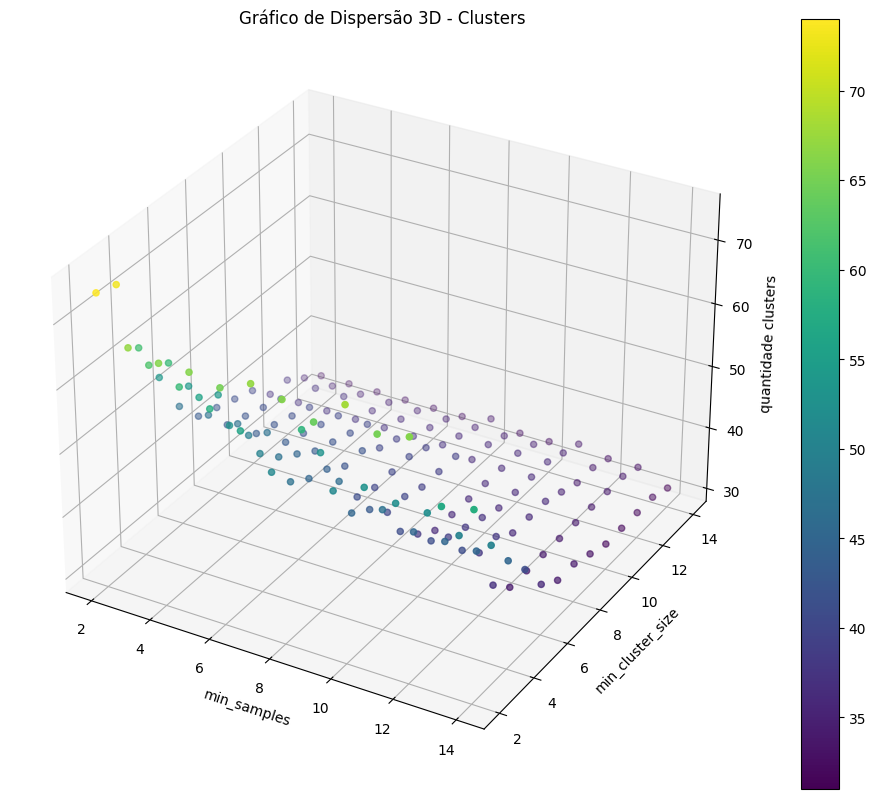

In [ ]:
x = df_metricas["min_samples"]
y = df_metricas["min_cluster_size"]
z = df_metricas["n_clusters"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

ax.set_xlabel('min_samples')
ax.set_ylabel('min_cluster_size')
ax.set_zlabel('quantidade clusters')

ax.set_title('Gráfico de Dispersão 3D - Clusters')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

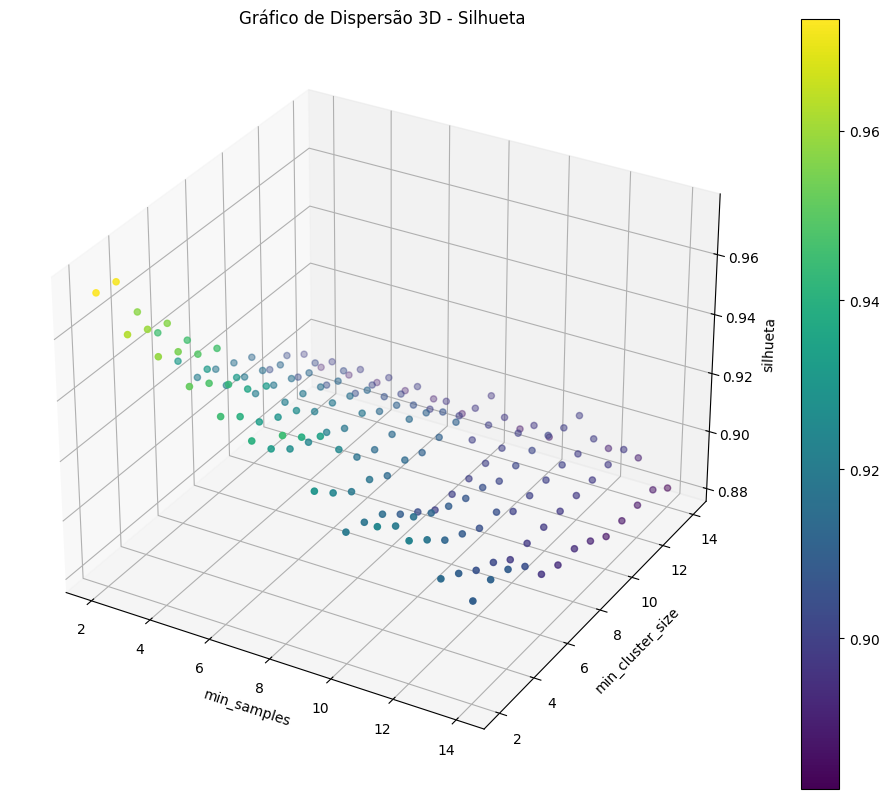

In [ ]:
x = df_metricas["min_samples"]
y = df_metricas["min_cluster_size"]
z = df_metricas["silhouette"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

ax.set_xlabel('min_samples')
ax.set_ylabel('min_cluster_size')
ax.set_zlabel('silhueta')

ax.set_title('Gráfico de Dispersão 3D - Silhueta')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

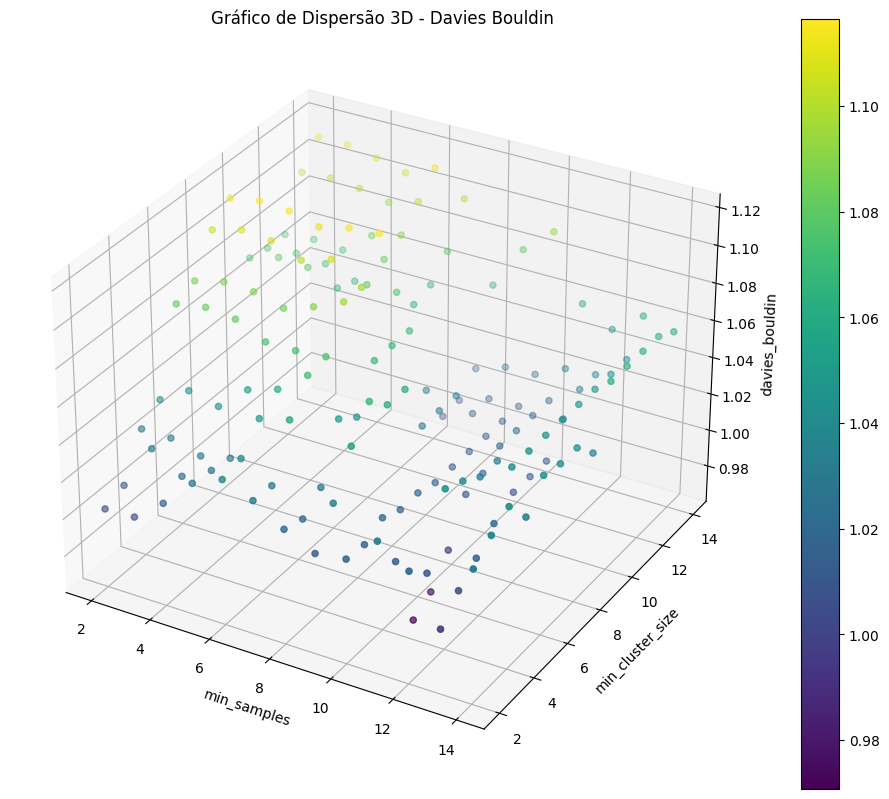

In [ ]:
x = df_metricas["min_samples"]
y = df_metricas["min_cluster_size"]
z = df_metricas["davies_bouldin"]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

ax.set_xlabel('min_samples')
ax.set_ylabel('min_cluster_size')
ax.set_zlabel('davies_bouldin')

ax.set_title('Gráfico de Dispersão 3D - Davies Bouldin')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

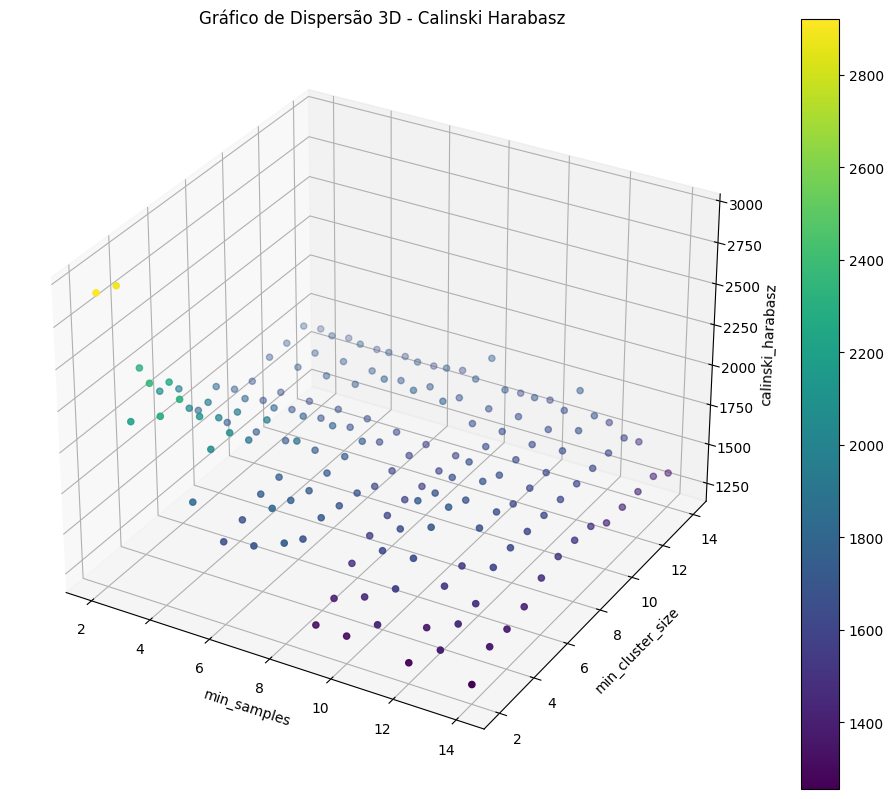

In [ ]:
x = df_metricas["min_samples"]
y = df_metricas["min_cluster_size"]
z = df_metricas["calinski_harabasz"]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

ax.set_xlabel('min_samples')
ax.set_ylabel('min_cluster_size')
ax.set_zlabel('calinski_harabasz')

ax.set_title('Gráfico de Dispersão 3D - Calinski Harabasz')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

In [ ]:
hdb = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=2)
clusters = hdb.fit_predict(tfidf_matrix)

In [ ]:
umap_embedding = umap.UMAP(n_neighbors=30,
    min_dist=0.0,
    n_components=3,
    random_state=42).fit_transform(tfidf_matrix.toarray())


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<ipython-input-26-2e2cdfcc9b1d>:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z,


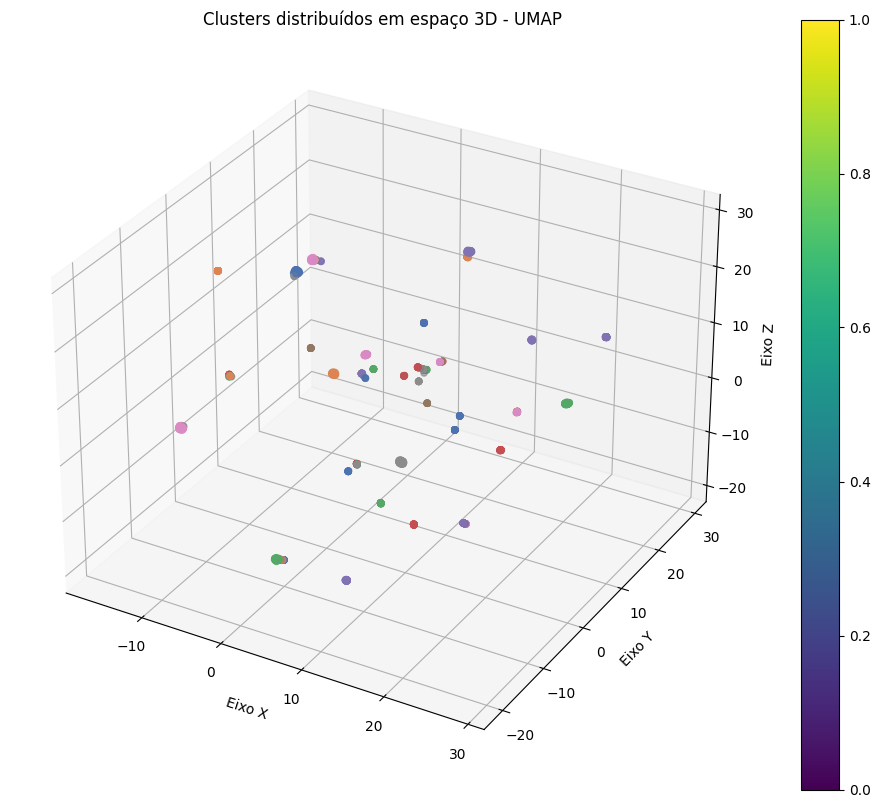

In [ ]:
color_palette = sns.color_palette('deep', 8)

color_palette = color_palette * (len(clusters) // len(color_palette) + 1)

cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusters]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, hdb.probabilities_)]

x = umap_embedding[:, 0]
y = umap_embedding[:, 1]
z = umap_embedding[:, 2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z,
                     c=cluster_member_colors,
                     cmap='viridis',
                     marker='o')

ax.set_title('Clusters distribuídos em espaço 3D - UMAP')
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

In [ ]:
umap_embedding = umap.UMAP(n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42).fit_transform(tfidf_matrix.toarray())


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
help(hdb)

Help on HDBSCAN in module hdbscan.hdbscan_ object:

class HDBSCAN(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin)
 |  HDBSCAN(min_cluster_size=5, min_samples=None, cluster_selection_epsilon=0.0, max_cluster_size=0, metric='euclidean', alpha=1.0, p=None, algorithm='best', leaf_size=40, memory=Memory(location=None), approx_min_span_tree=True, gen_min_span_tree=False, core_dist_n_jobs=4, cluster_selection_method='eom', allow_single_cluster=False, prediction_data=False, branch_detection_data=False, match_reference_implementation=False, **kwargs)
 |  
 |  Perform HDBSCAN clustering from vector array or distance matrix.
 |  
 |  HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications
 |  with Noise. Performs DBSCAN over varying epsilon values and integrates
 |  the result to find a clustering that gives the best stability over epsilon.
 |  This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN),
 |  and be more robust to parameter selection.
 |  
 |  

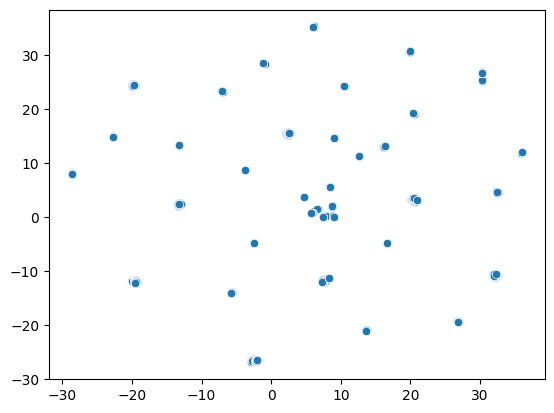

In [ ]:
color_palette = sns.color_palette('deep', 8)

color_palette = color_palette * (len(clusters) // len(color_palette) + 1)

cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusters]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, hdb.probabilities_)]

x = umap_embedding[:, 0]
y = umap_embedding[:, 1]

#fig, ax = plt.figure(figsize=(12, 10))
#ax = fig.add_subplot(111, projection='2d')
scatter = sns.scatterplot(x=x, y=y,
                     marker='o')

ax.set_title('Clusters distribuídos em espaço 2D - UMAP')
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')

# Adding a colorbar
#cbar = plt.colorbar(scatter)

plt.show()

In [ ]:
df_lotes['cluster'] = clusters

for c in set(clusters):
  try:
    sample = df_lotes[df_lotes['cluster'] == c].sample(3)
  except ValueError:
    sample = df_lotes[df_lotes['cluster'] == c]

  print(f"Cluster {c}:")
  for i, r in sample.iterrows():
    print(f"  - {r['descricao'][:70]}")
  print("\n")

Cluster 0:
  - MUSICA - UM PREMIO PARA EP DE ARTES URBANAS...
  - DANCA - GRUPOS DE DANCA FOLCLORICA...
  - ARTES VISUAIS - URBANA...


Cluster 1:
  - LOTE 09...
  - LIDOCAÍNA  cloridrato 5 mL (2%)...
  - LOTE 05...


Cluster 2:
  - LANTERNA TATICA PARA CAPACETE...
  - MATERIAL DE LIMPEZA...
  - CABO PARA SALVAMENTO...


Cluster 3:
  - MEIA BOLA BOSU ANTIESTOURO COM ALÇAS ESPECIFICAÇÕES DA MEIA ...
  - SHAKER – TERAPIA VIBRATÓRIA EXPIRATÓRIA PARA MOBILIZAÇÃO DE ...
  - HIP BAND ELÁSTICO ULTRA - KIT 3 PEÇAS MATERIAL69% POLIÉSTER ...


Cluster 4:
  - Cateteres Intravenoso  Estéril (esterilizado por óxido de et...
  - Scalp de Segurança Para infusão 21G...
  - Antiparasitário de alta concetração  solução injetável estér...


Cluster 5:
  - Jerimum caboclo - Apresentando tamanho uniforme  e suficient...
  - ABACAXI - TIPO PEROLA COM 70% DE MATURAÇÃO  SEM DANIFICAÇÕES...
  - Cenoura - Frescas de ótima qualidade  compacta  firme de col...


Cluster 6:
  - MANTEIGA DE GARRAFA - MANTEIGA  COM 

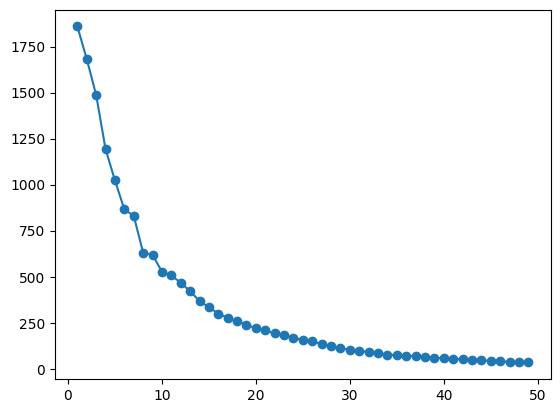

In [ ]:
# importando algoritmo k-means
from sklearn.cluster import KMeans
%matplotlib inline

# quantidade de grupos que vamos realizar os testes
ks = range(1, 50)
# armazena o valor do índice para cada partição gerada
inertias = []
for k in ks:
  # executa o k-means para aquela quantidade de grupos
  km = KMeans(n_clusters=k, random_state=8, n_init='auto')
  # aplica a configuração do agrupamento gerado aos dados para obter o índice
  km.fit(tfidf_matrix)
  # calcula o erro quadrático médio
  inertias.append(km.inertia_)
# plota o gráfico
plt.plot(ks, inertias, marker='o')

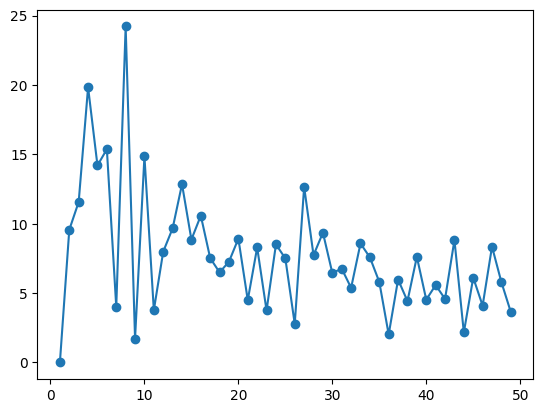

In [ ]:
diff = [(1 - (inertias[i] / inertias[i-1]))*100 if i > 0 else 0 for i in range(0,len(inertias))]
plt.plot(range(1,len(diff)+1), diff, marker='o')

In [ ]:
km = KMeans(n_clusters=20, random_state=10, n_init='auto')
# aplica a configuração do agrupamento gerado aos dados para obter o índice
km = km.fit(tfidf_matrix)
# calcula o erro quadrático médio
inertias.append(km.inertia_)

In [ ]:

# Resgata os filmes para cada cluster
cluster_representative_titles = get_cluster_representative_titles(km.cluster_centers_, tfidf_matrix.toarray(), df_lotes['descricao'])

# Exibe os filmes
for i, titles in enumerate(cluster_representative_titles):
    print(f"Cluster {i}:")
    for title in titles:
        print(f"  - {title}")
    print("\n")

NameError: name 'get_cluster_representative_titles' is not defined

## 5. Uso de _embeddings_



In [ ]:
import os

openai_api_key = input('Digite a chave da API do OpenAI: ')
os.environ['OPENAI_API_KEY'] = openai_api_key

In [ ]:
from langchain_openai import OpenAIEmbeddings

def get_vector(text):
  embed = OpenAIEmbeddings(model="text-embedding-3-large", openai_api_key=openai_api_key)
  return embed.embed_query(text)

#df_lotes['vector'] = df_lotes['texto_limpo'].apply(get_vector)
#df_lotes[['texto_limpo', 'vector']].to_excel('lotes_vetores.xlsx')

df_lotes_vector = pd.read_excel('lotes_vetores.xlsx')

In [ ]:
len(df_lotes['vector'] .iloc[0])

In [ ]:
df_lotes['vector'][:2]

In [ ]:
vetores = [x for x in df_lotes['vector']]

In [ ]:
km = KMeans(n_clusters=20, random_state=10, n_init='auto')
# aplica a configuração do agrupamento gerado aos dados para obter o índice
km = km.fit(vetores)
# calcula o erro quadrático médio
km.inertia_

In [ ]:
# Resgata os filmes para cada cluster
cluster_representative_titles = get_cluster_representatives(km.cluster_centers_,
                                                                  vetores,
                                                                  df_lotes['descricao'])

# Exibe os filmes
for i, titles in enumerate(cluster_representative_titles):
    print(f"Cluster {i}:")
    for title in titles:
        print(f"  - {title}")
    print("\n")

In [ ]:
km.labels_

In [ ]:
umap_embedding = umap.UMAP(n_neighbors=30,
    min_dist=0.0,
    n_components=3,
    random_state=42).fit_transform(vetores)


In [ ]:

color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in km.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, km.probabilities_)]

x = umap_embedding[:, 0]
y = umap_embedding[:, 1]
z = umap_embedding[:, 2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z,
                     c=cluster_member_colors,
                     cmap='viridis',
                     marker='o')

ax.set_title('Clusters distribuídos em espaço 3D - UMAP')
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()